In [1]:
import tensorflow as tf
from tensorflow import keras
import gym

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset(seed=42)

In [3]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [4]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [5]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

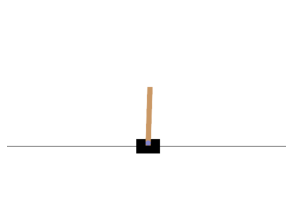

In [6]:
plot_environment(env)
plt.show()

In [7]:
env.action_space

Discrete(2)

In [8]:
action = 1
obs, reward, done, info = env.step(action)

In [9]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

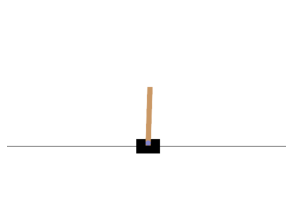

In [10]:
plot_environment(env)
plt.show(env)

In [11]:
reward

1.0

In [12]:
done

False

In [13]:
info

{}

In [14]:
if done:
    obs = env.reset()

In [15]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []

for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs) 
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [16]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

In [17]:
frames = []

obs = env.reset()
for step in range(100):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [18]:
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval)
    plt.close()
    return anim

In [19]:
plot_animation(frames)

In [20]:
keras.backend.clear_session()

n_inputs = 4

model = keras.models.Sequential([ 
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [21]:
def render_policy_net(model, n_max_steps=200):
    frames = []
    env = gym.make("CartPole-v1")
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [22]:
frames = render_policy_net(model)
plot_animation(frames)

In [23]:
n_environments = 50
n_iterations = 5000
np.random.seed(42)
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
observations = [env.reset(seed=seed) for seed, env in enumerate(envs)]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"\rIteration: {iteration}, Loss: {loss.numpy():.3f}", end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.076

In [24]:
frames = render_policy_net(model)
plot_animation(frames)

In [25]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [26]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [27]:
def discount_reward(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_reward(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [28]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [29]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [30]:
keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [31]:
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration : {iteration}, mean rewards : {total_rewards / n_episodes_per_update}", end="")
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index] 
            for episode_index, final_rewards in enumerate(all_final_rewards) 
            for step, final_reward in enumerate(final_rewards)],
            axis=0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration : 149, mean rewards : 90.37

In [32]:
frames = render_policy_net(model)
plot_animation(frames)

In [33]:
transition_probabilities = [
    [0.7, 0.2, 0.0, 0.1],
    [0.0, 0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]
n_max_steps = 50

def print_sequence():
    current_state = 0
    print("State : ", end="")
    for step in range(n_max_steps):
        print(current_state, end="")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

State : 0000012121212121212121213
State : 012121213
State : 00121213
State : 00121212121212121212121212121213
State : 013
State : 001213
State : 000012121212121212121212121213
State : 03
State : 003
State : 012121212121212121212121213


In [34]:
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [ 
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions= [[0, 1, 2], [0, 2], [1]]

In [35]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [36]:
gamma = 0.95
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)]
            )
history1 = np.array(history1)

In [37]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [38]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

In [39]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [40]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [41]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05
decay = 0.005
gamma = 0.95
state = 0
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1+iteration*decay)
    Q_values[state, action] *= 1-alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

In [42]:
Q_values

array([[19.4723742 , 17.92446393, 14.4052022 ],
       [ 0.        ,        -inf, -5.12055163],
       [       -inf, 49.88930034,        -inf]])

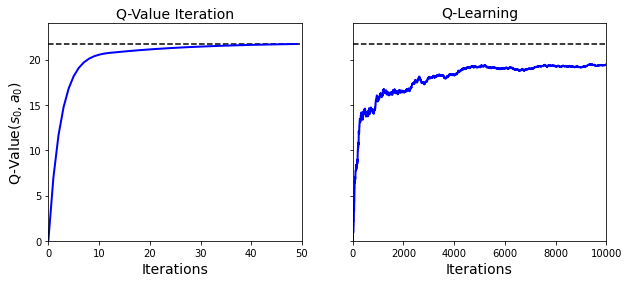

In [43]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])